In [ ]:
import utils
import torch
import torch
import torchvision
import torch.nn as nn
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.functional import F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/CAI/Phase 4/"

/content/drive/MyDrive/CAI/Phase 4


In [ ]:
A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = utils.get_oxford_splits(batch_size = 64)

100%|██████████| 344862509/344862509 [00:12<00:00, 26776925.77it/s]


Extracting /content/data/flowers-102/102flowers.tgz to /content/data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 517077.75it/s]


100%|██████████| 14989/14989 [00:00<00:00, 10514872.50it/s]


In [ ]:
len(A_train_dl.dataset), len(A_test_dl.dataset)

(4617, 1538)

In [ ]:
len(B_train_dl.dataset), len(B_test_dl.dataset)

(100, 518)

In [ ]:
len(test_all.dataset)

2056

# Model

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

In [ ]:
class model(nn.Module):
  def __init__(self):
    super(model, self).__init__()
    self.conv1 = ConvBlock(3, 64, 3, 1, 1)
    self.conv2 = nn.Sequential(
        *([ConvBlock(64, 64, 3, 1, 1) for _ in range(4)])
    )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Sequential(
        ConvBlock(64, 96, 3, 1, 1),
        ConvBlock(96, 96, 3, 1, 1),
        ConvBlock(96, 96, 3, 1, 1),
        ConvBlock(96, 96, 3, 1, 1),
    )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv4 = nn.Sequential(
        ConvBlock(96, 128, 3, 1, 1),
        ConvBlock(128, 128, 3, 1, 1),
        ConvBlock(128, 128, 3, 1, 1),
        ConvBlock(128, 128, 3, 1, 1),
    )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv5 = nn.Sequential(
        ConvBlock(128, 256, 3, 1, 1),
        ConvBlock(256, 256, 3, 1, 1),
        ConvBlock(256, 256, 3, 1, 1),
        ConvBlock(256, 256, 3, 1, 1),
    )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(256 * 4 * 4, 80)

  def forward(self, x):
    x0 = self.conv1(x)
    x1 = self.conv2(x0)
    x2 = self.pool1(x1)
    x3 = self.conv3(x2)
    x4 = self.pool2(x3)
    x5 = self.conv4(x4)
    x6 = self.pool3(x5)
    x7 = self.conv5(x6)
    x8 = self.pool4(x7)
    x9 = self.flatten(x8)
    x10 = self.fc(x9)
    return x10

In [ ]:
model = model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(model)

cuda
model(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

# Train - Test

In [ ]:
num_batches = len(A_train_dl)
num_samples = len(A_train_dl.dataset)
acc_history = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
min_delta = 0.005
patience = 6
best_loss = float('inf')
best_accuracy = 0

counter = 0

for epoch in range(80):
    print("Epoch", str(epoch) + "/100")
    # Train
    model_save_dir = 'saved_models'
    os.makedirs(model_save_dir, exist_ok=True)
    model.train()
    correct = 0
    total_loss = 0.0
    for (data, target) in A_train_dl:
        data = data.to(device)
        target = target.to(device)  # Move target to the same device as data

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predictions = torch.max(output, dim=1)
        correct += torch.sum(predictions == target)
        total_loss += loss.item()
    epoch_accuracy = (correct / num_samples) * 100
    epoch_loss = total_loss / num_batches
    acc_history['train'].append(epoch_accuracy)
    loss_history['train'].append(epoch_loss)
    print('Train - Accuracy:', str(epoch_accuracy.item()) + ', Loss:' , epoch_loss)

    #Test
    model.eval()
    total = 0
    correct = 0
    total_loss += 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in A_test_dl:
            data = data.to(device)
            target = target.to(device)  # Move target to the same device as data
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            total_loss += loss.item()
            y_true.extend(target.tolist())
            y_pred.extend(predicted.tolist())

    accuracy = 100 * correct / total
    epoch_loss = total_loss / num_batches
    acc_history['test'].append(accuracy)
    loss_history['test'].append(epoch_loss)
    print('Test - Accuracy:', str(accuracy) + ', Loss:' , epoch_loss)
    print()

    if accuracy > best_accuracy:
                best_accuracy = accuracy
                model_checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': accuracy,
                    'loss': epoch_loss
                }
                model_save_path = os.path.join(model_save_dir, f'model_best_accuracy.pt')
                torch.save(model_checkpoint, model_save_path)

Epoch 0/100
Train - Accuracy: 11.999134063720703, Loss: 3.7827264348121536
Test - Accuracy: 19.4408322496749, Loss: 4.836926597438446

Epoch 1/100
Train - Accuracy: 31.817197799682617, Loss: 2.7086928250038462
Test - Accuracy: 37.711313394018205, Loss: 3.5281810825818205

Epoch 2/100
Train - Accuracy: 45.614036560058594, Loss: 2.0675328937295365
Test - Accuracy: 45.51365409622887, Loss: 2.7846204532335883

Epoch 3/100
Train - Accuracy: 57.22330856323242, Loss: 1.6215204490374213
Test - Accuracy: 44.993498049414825, Loss: 2.1183680704195207

Epoch 4/100
Train - Accuracy: 65.99523162841797, Loss: 1.2682282745021662
Test - Accuracy: 57.607282184655396, Loss: 1.725221331805399

Epoch 5/100
Train - Accuracy: 75.67684936523438, Loss: 0.9676973991198082
Test - Accuracy: 55.851755526657996, Loss: 1.2042102013548759

Epoch 6/100
Train - Accuracy: 82.6294174194336, Loss: 0.7399126454575421
Test - Accuracy: 60.33810143042913, Loss: 1.0117371172121126

Epoch 7/100
Train - Accuracy: 87.849250793457

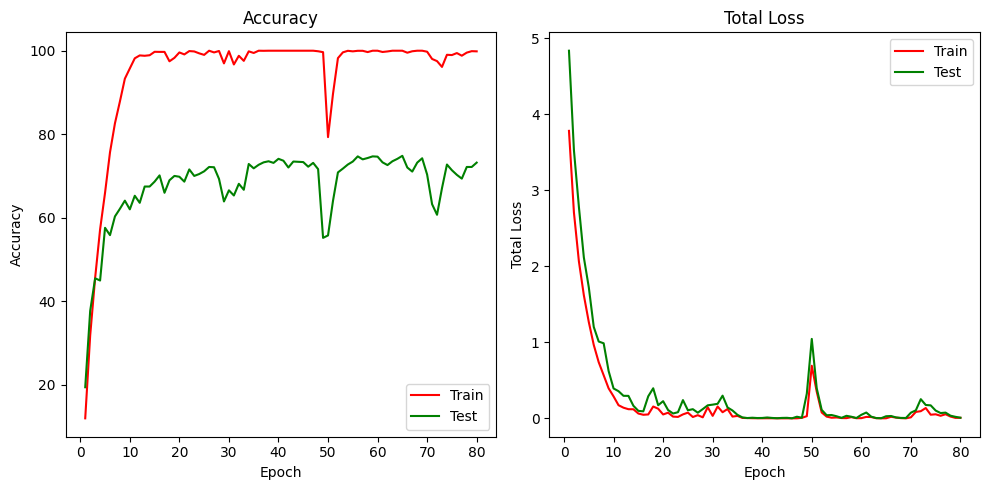

In [ ]:
info_to_plot([acc_history, loss_history], epoch)

In [ ]:
def info_to_plot(result, epoch):
    train_accs = result[0]['train']
    train_total_losses = result[1]['train']

    test_accs = result[0]['test']
    test_total_losses = result[1]['test']

    train_accs = np.array([item.item() if hasattr(item, 'item') else item for item in train_accs])
    train_total_losses = np.array([item.item() if hasattr(item, 'item') else item for item in train_total_losses])

    test_accs = np.array([item.item() if hasattr(item, 'item') else item for item in test_accs])
    test_total_losses = np.array([item.item() if hasattr(item, 'item') else item for item in test_total_losses])

    plotter(train_accs, train_total_losses, test_accs, test_total_losses, epoch)

In [ ]:
def plotter(train_accs, train_total_losses, test_accs, test_total_losses, epoch):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted figsize for clarity
    ranges = [i for i in range(1 , epoch+2)]



    axs[0].plot(ranges, train_accs, color='red', label='Train')
    axs[0].plot(ranges, test_accs, color='green', label='Test')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(ranges, train_total_losses, color='red', label='Train')
    axs[1].plot(ranges, test_total_losses, color='green', label='Test')
    axs[1].set_title('Total Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Total Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig('accuracy_and_loss_plot.png', dpi=100)  # Adjusted filename


In [ ]:
model_checkpoint_path = '/content/drive/MyDrive/CAI/Phase 4/saved_models/model_best_accuracy.pt'
checkpoint = torch.load(model_checkpoint_path)

epoch_num = checkpoint['epoch']
accuracy = checkpoint['accuracy']


print("Epoch Number:", epoch_num)
print("Test Accuracy: ", accuracy)


Epoch Number: 64
Test Accuracy:  74.83745123537061
